In [32]:
import methylize
import methylcheck
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

### Differentially methylated regions (DMRs)

Genomic regions where DNA methylation levels differ between two groups of samples.

Beta or m-values can be used, but the format needs to be samples as rows and probes as columns.

In [2]:
betas, meta = methylcheck.load_both('data/asthma')
betas = betas.T
print(meta.shape)
meta.head()

INFO:methylcheck.load_processed:Found several meta_data files; attempting to match each with its respective beta_values files in same folders.
INFO:methylcheck.load_processed:Multiple meta_data found. Only loading the first file.
INFO:methylcheck.load_processed:Loading 40 samples.
Files: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]
INFO:methylcheck.load_processed:loaded data (485512, 40) from 1 pickled files (0.109s)
INFO:methylcheck.load_processed:Transposed data and reordered meta_data so sample ordering matches.
INFO:methylcheck.load_processed:meta.Sample_IDs match data.index (OK)


(40, 19)


,tissue,disease,smoking_status,passage,Sex,age,description,Sample_ID,Sentrix_ID,Sentrix_Position,Sample_Group,Sample_Name,Sample_Plate,Sample_Type,Sub_Type,Sample_Well,Pool_ID,GSM_ID,Control
20,Airway Fibroblast,Healthy,Ex,4,M,65,fun2norm normalized average beta,9976861129_R03C01,9976861129,R03C01,None,HAF091,None,Unknown,None,None,None,GSM4772065,False
38,Parenchymal Fibroblast,Asthmatic,Non,4,F,19,fun2norm normalized average beta,9976861129_R04C02,9976861129,R04C02,None,7294_P4_LG,None,Unknown,None,None,None,GSM4772083,False
37,Parenchymal Fibroblast,Asthmatic,Non,4,F,14,fun2norm normalized average beta,9976861129_R05C01,9976861129,R05C01,None,7291_lg_p4,None,Unknown,None,None,None,GSM4772082,False
32,Parenchymal Fibroblast,Asthmatic,Current,4,F,15,fun2norm normalized average beta,9976861129_R06C02,9976861129,R06C02,None,7188_lg_p4_R,None,Unknown,None,None,None,GSM4772077,False
23,Airway Fibroblast,Asthmatic,Non,4,F,8,fun2norm normalized average beta,9976861137_R06C01,9976861137,R06C01,None,7016_BR_P4,None,Unknown,None,None,None,GSM4772068,False


The phenotypes can be anything list-like (i.e. a list, numpy array, or Pandas series). When using Logistic Regression DMP, use phenotype data that is binary (has only 2 classes). When using Linear Regression DMP, use phenotype data that is numeric, such as age.

(40,)


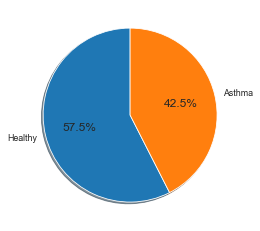

In [45]:
pheno_data = meta.disease
print(pheno_data.shape)
dummies = pd.get_dummies(meta, columns=['disease'])[['disease_Asthmatic', 'disease_Healthy']]
healthy = dummies.disease_Healthy.sum()
asthma = dummies.disease_Asthmatic.sum()
fig1, ax1 = plt.subplots()
ax1.pie((healthy, asthma), labels=['Healthy', 'Asthma'], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

This function searches for individual differentially methylated positions/probes (DMPs) by regressing the methylation beta or M-value for each sample at a given genomic location against the phenotype data for those samples.

`impute` argument:
* Default: ‘delete’ probes if any samples have missing data for that probe. 
* True or ‘auto’: if <30 samples, deletes rows; if >=30 samples, uses average. 
* False: don’t impute and throw an error if NaNs present ‘average’ - use the average of probe values in this batch ‘delete’ - drop probes if NaNs are present in any sample 
* ‘fast’ - use adjacent sample probe value instead of average (much faster but less precise)

Note: if you want to analyze every probe in your betas dataframe, remove the `.sample(N)`. What this does is randomly samples `N` probes from your dataframe and decreases the time it takes to complete this analysis.

In [4]:
test_results = methylize.diff_meth_pos(betas.sample(20000, axis=1), pheno_data, regression_method="logistic", export=False)

All samples with the phenotype (Healthy) were assigned a value of 0 and all samples with the phenotype (Asthmatic) were assigned a value of 1 for the logistic regression analysis.


  0%|          | 0/17119 [00:00<?, ?it/s]

After we run the DMP analysis, we can move on to visualizing the results. One way to do this is a Manhattan plot.



INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450k_15017482_v3.csv


Total probes to plot: 17119
01 1679 | 02 1256 | 03 876 | 04 717 | 05 848 | 06 1256 | 07 1014 | 08 803 | 09 376 | 10 850 | 11 1035 | 12 899 | 13 408 | 14 547 | 15 485 | 16 765 | 17 971 | 18 229 | 19 870 | 20 397 | 21 145 | 22 301 | X 392


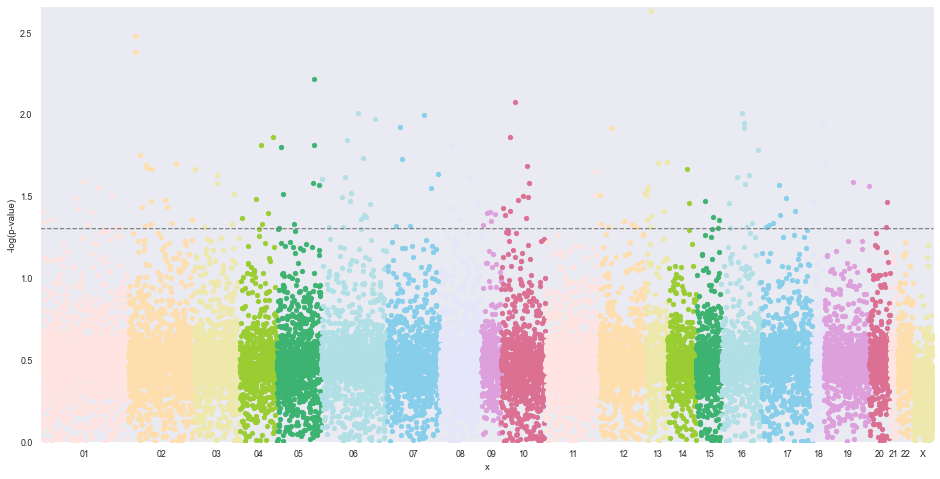

In [47]:
methylize.manhattan_plot(test_results, cutoff=0.05, palette='default', save=False, array_type='450k', post_test=None)

To see which probes are significant (above the cutoff line in the Manhattan plot), filter the results dataframe by the p-value.

In [6]:
interesting_probes = test_results[test_results['PValue'] <= 0.05]
interesting_probes

,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,FDR_QValue,minuslog10pvalue,chromosome,MAPINFO
cg10836101,-16.187566,7.277279,0.026122,-30.450771,-1.924361,0.551144,1.582999,19,CHR-29529979.0
cg18501026,-3.122809,1.377182,0.023358,-5.822037,-0.423581,0.551144,1.631572,03,CHR-50674665.0
cg12782992,-3.945388,1.831835,0.031257,-7.535720,-0.355057,0.551144,1.505057,11,CHR-9004508.0
cg07116393,-24.375851,11.077786,0.027777,-46.087913,-2.663790,0.551144,1.556320,01,CHR-20508350.0
cg12325536,-4.775416,2.160739,0.027099,-9.010386,-0.540446,0.551144,1.567042,05,CHR-88672840.0
...,...,...,...,...,...,...,...,...,...
cg03036557,-6.108672,2.006893,0.002336,-10.042110,-2.175234,0.551144,2.631574,13,CHR-91398466.0
cg25482900,-7.416444,3.077287,0.015950,-13.447816,-1.385073,0.551144,1.797242,05,CHR-168529906.0
cg08802944,-1.078843,0.547216,0.048665,-2.151366,-0.006320,0.551144,1.312781,12,CHR-53480976.0
cg16485048,-2.621240,1.270725,0.039133,-5.111816,-0.130665,0.551144,1.407462,10,CHR-13707193.0


In order to find DMPs against a numeric continuous phenotype, the `linear` regression method must be used.

(40,)


Text(0, 0.5, 'Frequency')

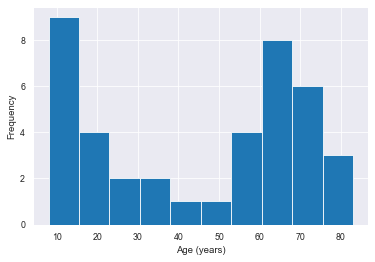

In [23]:
pheno_data = meta.age.astype(int)
print(pheno_data.shape)
(pheno_data.sort_values()).hist()
plt.xlabel('Age (years)'); plt.ylabel('Frequency')

In [8]:
test_results2 = methylize.diff_meth_pos(betas.sample(20000, axis=1), pheno_data, regression_method="linear", export=False)

  0%|          | 0/17031 [00:00<?, ?it/s]

INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450k_15017482_v3.csv


Total probes to plot: 17031
01 1603 | 02 1230 | 03 955 | 04 707 | 05 840 | 06 1291 | 07 1000 | 08 702 | 09 358 | 10 872 | 11 1053 | 12 906 | 13 427 | 14 546 | 15 502 | 16 777 | 17 1002 | 18 204 | 19 895 | 20 381 | 21 139 | 22 279 | X 362


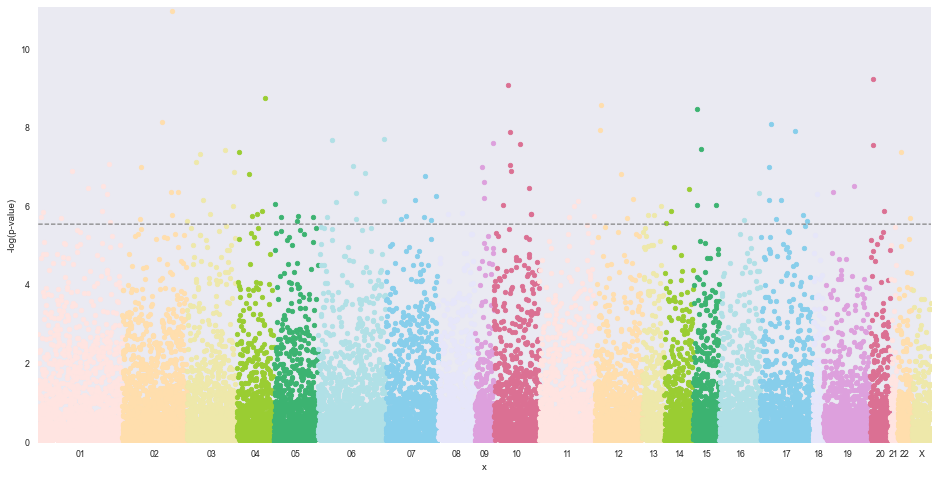

In [9]:
methylize.manhattan_plot(test_results2, cutoff=0.05, palette='default', save=False, array_type='450k', verbose=True)

For this Manhattan plot, there has been a p-value cuttoff correction, meaning that the cutoff line is at a more conservative value (lower p-value, higher cutoff line) to account for false positives. Because of this correction, when filtering the results dataframe to find significant probes, you need to filter by `<= -log(p-value)` to find the probes above the cutoff line on the Manhattan plot.

In [14]:
adjusted = multipletests(test_results2.PValue, alpha=0.05)
pvalue_cutoff_y = -np.log10(adjusted[3])
interesting_probes2 = test_results2[test_results2['minuslog10pvalue'] >= pvalue_cutoff_y] #bonferoni correction for cutoff
interesting_probes2

,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,Rsquared,FDR_QValue,minuslog10pvalue,chromosome,MAPINFO
cg01717446,0.004907,0.000512,1.100040e-11,0.840730,0.841318,0.707322,1.873479e-07,10.958591,02,CHR-71276436.0
cg03485533,-0.002718,0.000336,8.658062e-10,-0.795679,-0.795195,0.632721,4.915182e-06,9.062579,10,CHR-103459214.0
cg22154859,-0.004256,0.000517,5.787973e-10,-0.800564,-0.799834,0.640319,4.915182e-06,9.237474,20,CHR-54206638.0
cg23995914,0.004157,0.000530,1.804656e-09,0.786024,0.786816,0.618457,7.683774e-06,8.743606,04,CHR-10457604.0
cg01018437,-0.001667,0.000216,2.802206e-09,-0.780969,-0.780638,0.609653,9.544874e-06,8.552500,12,CHR-49951982.0
...,...,...,...,...,...,...,...,...,...,...
cg07130639,-0.002846,0.000513,2.362982e-06,-0.669612,-0.668501,0.447637,4.046358e-04,5.626540,16,CHR-89079484.0
cg03341377,-0.001861,0.000336,2.399637e-06,-0.669095,-0.668368,0.447202,4.046358e-04,5.619854,03,CHR-39267864.0
cg16969368,0.003723,0.000672,2.467052e-06,0.667415,0.668874,0.446418,4.119251e-04,5.607822,17,CHR-59565391.0
cg11684541,-0.002867,0.000520,2.638618e-06,-0.667283,-0.666151,0.444512,4.362943e-04,5.578623,01,CHR-30688423.0


Below shows how to create a Volcano plot using the linear regression DMR analysis. 

Positive correlation (**hypermethylated**) in <font color='red'>red</font>.
Negative correclation (**hypomethylated**) in <font color='blue'>blue</font>

A higher `|beta coefficient|` means that that specific probe is more significant in predicting if the probe is methylated (positive) vs not methylated (negative). The non-gray probes are the probes that are statistically significant, and have a higher absolute value of the regression coefficient as the cutoff. The red probes further to the right on the plot are hypermethylated with increase in age, and the opposite is true for the blue probes.

Useful Arguments:
* `cutoff`: Default: 0.05 alpha level The significance level that will be used to highlight the most significant adjusted p-values (FDR Q-values) on the plot. This is the horizontal cutoff line you see on the plot.
* `beta_coefficient_cutoff`: Default: No cutoff format: a list or tuple with two numbers for (min, max) If specified in kwargs, will exclude values within this range of regression coefficients from being “significant” and put dotted vertical lines on chart. These are the vertical cutoff lines you see on the plot. These cutoffs are dependent on the study and up to the researcher in choosing which cutoff is the most desirable.

In [ ]:
methylize.volcano_plot(test_results2, fontsize=16, cutoff=0.05, beta_coefficient_cutoff=(-0.0005,0.0005), save=False)

In [ ]:
interesting_probes3 = test_results2[test_results['PValue'] <= -np.log10(0.05)]